### Acrobat-v1:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ActorCritic(nn.Module):
    def __init__(self, input_dim, num_actions):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.actor = nn.Linear(128, num_actions)
        self.critic = nn.Linear(128, 1)
        for layer in (self.fc1, self.fc2, self.actor, self.critic):
            nn.init.orthogonal_(layer.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.actor(x), self.critic(x)

class Worker(mp.Process):
    def __init__(self, env_name, gnet, optimizer, global_ep, res_queue, config):
        super().__init__()
        self.env = gym.make(env_name)
        self.g_ep = global_ep
        self.res_queue = res_queue
        self.gnet = gnet
        self.optimizer = optimizer
        self.config = config
        self.device = device
        obs_dim = self.env.observation_space.shape[0]
        action_n = self.env.action_space.n
        self.lnet = ActorCritic(obs_dim, action_n).to(self.device)
        self.lnet.load_state_dict(gnet.state_dict())

    def run(self):
        total_step = 1

        while self.g_ep.value < self.config['max_eps']:
            state, _ = self.env.reset()
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0
            done = False

            while not done:
                s_tensor = torch.tensor(state, dtype=torch.float32, device=self.device).unsqueeze(0)
                logits, _ = self.lnet(s_tensor)
                probs = F.softmax(logits, dim=-1)
                dist = torch.distributions.Categorical(probs)
                a = dist.sample().item()
                next_state, reward, terminated, truncated, _ = self.env.step(a)
                done = terminated or truncated
                buffer_s.append(state)
                buffer_a.append(a)
                buffer_r.append(reward * self.config['reward_scale'])
                ep_r += reward
                state = next_state
                total_step += 1
                if total_step % self.config['update_interval'] == 0 or done:
                    self._update_global(done, next_state, buffer_s, buffer_a, buffer_r)
                    buffer_s, buffer_a, buffer_r = [], [], []

            with self.g_ep.get_lock():
                self.g_ep.value += 1
            self.res_queue.put(ep_r)

    def _update_global(self, done, next_state, states, actions, rewards):
        if done:
            R = 0
        else:
            s_ = torch.tensor(next_state, dtype=torch.float32, device=self.device).unsqueeze(0)
            _, v = self.lnet(s_)
            R = v.item()
        v_targets = []

        for r in reversed(rewards):
            R = r + self.config['gamma'] * R
            v_targets.append(R)

        v_targets.reverse()
        loss = self._compute_loss(states, actions, v_targets)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.lnet.parameters(), self.config['grad_clip'])

        for lp, gp in zip(self.lnet.parameters(), self.gnet.parameters()):
            if gp.grad is None:
                gp.grad = lp.grad.clone()
            else:
                gp.grad += lp.grad
        self.optimizer.step()
        self.lnet.load_state_dict(self.gnet.state_dict())

    def _compute_loss(self, states, actions, targets):
        s = torch.tensor(np.array(states), dtype=torch.float32, device=self.device)
        t = torch.tensor(np.array(targets), dtype=torch.float32, device=self.device)
        logits, values = self.lnet(s)
        dist = torch.distributions.Categorical(F.softmax(logits, dim=-1))
        a = torch.tensor(np.array(actions), dtype=torch.long, device=self.device)
        log_probs = dist.log_prob(a)
        entropy = dist.entropy().mean()
        values = values.view(-1)
        t = t.view(-1)
        advantage = t - values.detach()
        actor_loss = -(log_probs * advantage).mean()
        critic_loss = F.mse_loss(values, t)
        return actor_loss + 0.5 * critic_loss - self.config['entropy_beta'] * entropy

def train(env_name, config):
    print(f"Starting training on {env_name} for {config['max_eps']} episodes")
    env = gym.make(env_name)
    obs_dim = env.observation_space.shape[0]
    action_n = env.action_space.n
    gnet = ActorCritic(obs_dim, action_n).to(device)
    gnet.share_memory()
    optimizer = optim.Adam(gnet.parameters(), lr=config['lr'])
    global_ep = mp.Value('i', 0)
    res_queue = mp.Queue()
    workers = [Worker(env_name, gnet, optimizer, global_ep, res_queue, config)
               for _ in range(config['num_workers'])]

    for w in workers:
        w.start()

    rewards = []

    while global_ep.value < config['max_eps']:
        r = res_queue.get()
        if r is not None:
            rewards.append(r)
            if len(rewards) % config['print_interval'] == 0:
                print(f"Episode {len(rewards)} | Reward: {r:.2f}")

    for w in workers:
        w.join()

    model_path = f'{env_name}_a3c.pth'
    torch.save(gnet.state_dict(), model_path)
    print(f"Saved model weights to {model_path}")
    plt.figure(figsize=(8, 4))
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title(f'Rewards on {env_name}')
    plt.savefig(f'{env_name}_rewards.png')
    print(f"Saved rewards plot to {env_name}_rewards.png")
    plt.show()
    plt.close()
    return gnet

def evaluate(env_name, gnet, config, episodes=10):
    env = gym.make(env_name)
    rewards = []

    for _ in range(episodes):
        state, _ = env.reset()
        done, ep_r = False, 0

        while not done:
            s_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            logits, _ = gnet(s_tensor)
            action = torch.argmax(logits, dim=-1).item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_r += reward

        rewards.append(ep_r)

    plt.figure(figsize=(6, 4))
    plt.bar(range(1, episodes + 1), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title(f'Evaluation Rewards on {env_name}')
    plt.savefig(f"{env_name}_eval_rewards.png")
    plt.show()
    plt.close()
    print(f"Evaluation on {env_name}: {rewards}")

if __name__ == '__main__':
    mp.set_start_method('spawn', force=True)
    config = {
        'lr': 1e-4,
        'gamma': 0.99,
        'entropy_beta': 0.01,
        'update_interval': 20,
        'reward_scale': 1.0,
        'grad_clip': 0.5,
        'num_workers': 4,
        'max_eps': 20000,
        'print_interval': 50
    }
    env_name = 'Acrobot-v1'
    gnet = train(env_name, config)
    evaluate(env_name, gnet, config)

In [1]:
!pip install swig
!pip install "gymnasium[box2d]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379413 sha256=e9ae970e0be09cdb3cbc97faca7108e6370df2fda99dc7a10f32657ab20337b4
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [10]:
!python test1.py

Starting training on Acrobot-v1 for 20000 episodes
Episode 10 | Reward: -500.00
Episode 20 | Reward: -500.00
Episode 30 | Reward: -500.00
Episode 40 | Reward: -500.00
Episode 50 | Reward: -500.00
Episode 60 | Reward: -500.00
Episode 70 | Reward: -500.00
Episode 80 | Reward: -500.00
Episode 90 | Reward: -500.00
Episode 100 | Reward: -500.00
Episode 110 | Reward: -500.00
Episode 120 | Reward: -500.00
Episode 130 | Reward: -500.00
Episode 140 | Reward: -500.00
Episode 150 | Reward: -428.00
Episode 160 | Reward: -384.00
Episode 170 | Reward: -387.00
Episode 180 | Reward: -207.00
Episode 190 | Reward: -247.00
Episode 200 | Reward: -235.00
Episode 210 | Reward: -233.00
Episode 220 | Reward: -190.00
Episode 230 | Reward: -221.00
Episode 240 | Reward: -169.00
Episode 250 | Reward: -181.00
Episode 260 | Reward: -239.00
Episode 270 | Reward: -181.00
Episode 280 | Reward: -171.00
Episode 290 | Reward: -205.00
Episode 300 | Reward: -174.00
Episode 310 | Reward: -389.00
Episode 320 | Reward: -174.0

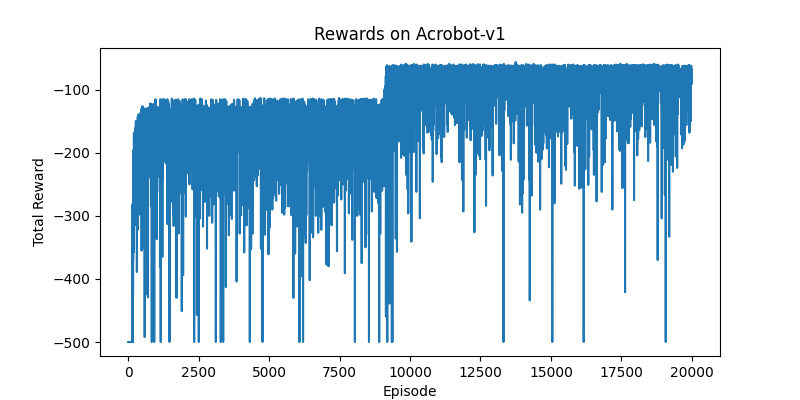

In [11]:
from IPython.display import Image, display

display(Image('/content/Acrobot-v1_rewards.png'))


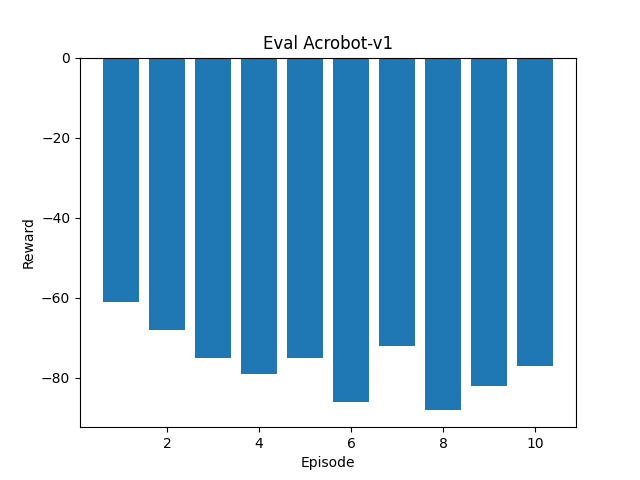

In [15]:
display(Image('/content/Acrobot-v1_evaluation.png'))

### Bipedalwalker-v3:

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing as mp
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

GAMMA = 0.99
LR = 3e-4
MAX_EPISODES = 2000
UPDATE_INTERVAL = 20
ENV_NAME = "BipedalWalker-v3"
NUM_WORKERS = 4
ENTROPY_BETA = 0.01
GRAD_CLIP = 0.5
REWARD_SCALE = 0.1
EPSILON_DECAY_RATE = 0.99
MIN_EPSILON = 0.01
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
results_dir = f"results_{ENV_NAME}_{timestamp}"
os.makedirs(results_dir, exist_ok=True)

class ActorCritic(nn.Module):
    def __init__(self, input_dim=24, output_dim=4):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(input_dim, 400)
        self.fc2 = nn.Linear(400, 300)
        self.mu = nn.Linear(300, output_dim)
        self.sigma = nn.Linear(300, output_dim)
        self.critic = nn.Linear(300, 1)
        self._initialize_weights()

    def _initialize_weights(self):

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0.0)

        nn.init.uniform_(self.mu.weight, -3e-3, 3e-3)
        nn.init.uniform_(self.sigma.weight, -3e-3, 3e-3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = torch.tanh(self.mu(x))
        sigma = F.softplus(self.sigma(x)) + 0.001
        value = self.critic(x)
        return mu, sigma, value

class Worker(mp.Process):
    def __init__(self, gnet, optimizer, global_ep, res_queue, name):
        super(Worker, self).__init__()
        self.name = f"worker_{name}"
        self.env = gym.make(ENV_NAME)
        self.input_dim = self.env.observation_space.shape[0]
        self.output_dim = self.env.action_space.shape[0]
        self.g_ep = global_ep
        self.res_queue = res_queue
        self.gnet = gnet
        self.optimizer = optimizer
        self.lnet = ActorCritic(self.input_dim, self.output_dim).to(DEVICE)
        self.lnet.load_state_dict(self.gnet.state_dict())

    def run(self):
        total_step = 1
        worker_rewards = []
        epsilon = 1.0

        while self.g_ep.value < MAX_EPISODES:
            state, _ = self.env.reset()
            buffer_s, buffer_a, buffer_r = [], [], []
            ep_r = 0
            episode_length = 0

            while True:
                s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
                mu, sigma, _ = self.lnet(s_tensor)
                normal_dist = torch.distributions.Normal(mu, sigma)
                action = normal_dist.sample().cpu().numpy().flatten()
                if np.random.rand() < epsilon:
                    action = self.env.action_space.sample()
                action = np.clip(action, -1.0, 1.0)
                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                next_state = obs
                buffer_s.append(state)
                buffer_a.append(action)
                buffer_r.append(reward * REWARD_SCALE)
                ep_r += reward
                state = next_state
                episode_length += 1
                epsilon = max(epsilon * EPSILON_DECAY_RATE, MIN_EPSILON)
                if total_step % UPDATE_INTERVAL == 0 or done:
                    self.update_global(done, next_state, buffer_s, buffer_a, buffer_r)
                    buffer_s, buffer_a, buffer_r = [], [], []
                if done:

                    with self.g_ep.get_lock():
                        self.g_ep.value += 1

                    self.res_queue.put((self.name, ep_r, episode_length, epsilon))
                    worker_rewards.append(ep_r)
                    break
                total_step += 1

    def update_global(self, done, next_state, bs, ba, br):
        if done:
            R = 0
        else:
            s_ = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
            _, _, v = self.lnet(s_)
            R = v.item()
        buffer_v_target = []

        for r in reversed(br):
            R = r + GAMMA * R
            buffer_v_target.append(R)

        buffer_v_target.reverse()
        loss = self.compute_loss(bs, ba, buffer_v_target)
        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.lnet.parameters(), GRAD_CLIP)

        for lp, gp in zip(self.lnet.parameters(), self.gnet.parameters()):
            if gp.grad is None:
                gp._grad = lp.grad
            else:
                gp._grad += lp.grad

        self.optimizer.step()
        self.lnet.load_state_dict(self.gnet.state_dict())

    def compute_loss(self, states, actions, targets):
        states_np = np.array(states, dtype=np.float32)
        actions_np = np.array(actions, dtype=np.float32)
        targets_np = np.array(targets, dtype=np.float32)
        s = torch.tensor(states_np, dtype=torch.float32).to(DEVICE)
        a = torch.tensor(actions_np, dtype=torch.float32).to(DEVICE)
        t = torch.tensor(targets_np, dtype=torch.float32).to(DEVICE)
        mu, sigma, values = self.lnet(s)
        normal_dist = torch.distributions.Normal(mu, sigma)
        log_probs = normal_dist.log_prob(a).sum(dim=1)
        entropy = normal_dist.entropy().sum(dim=1).mean()
        advantage = t - values.squeeze()
        actor_loss = -(log_probs * advantage.detach()).mean()
        critic_loss = F.mse_loss(values.view(-1), t.view(-1))
        total_loss = actor_loss + 0.5 * critic_loss - ENTROPY_BETA * entropy
        return total_loss

def train():
    input_dim = gym.make(ENV_NAME).observation_space.shape[0]
    output_dim = gym.make(ENV_NAME).action_space.shape[0]
    gnet = ActorCritic(input_dim, output_dim).to(DEVICE)
    gnet.share_memory()
    optimizer = torch.optim.Adam(gnet.parameters(), lr=LR)
    global_ep = mp.Value('i', 0)
    res_queue = mp.Queue()
    workers = [Worker(gnet, optimizer, global_ep, res_queue, i) for i in range(NUM_WORKERS)]
    [w.start() for w in workers]
    rewards = []
    episode_lengths = []
    epsilon_values = []
    worker_rewards = {f'worker_{i}': [] for i in range(NUM_WORKERS)}
    episode = 0

    while True:
        msg = res_queue.get()
        if msg is not None:
            worker_name, r, episode_length, epsilon = msg
            rewards.append(r)
            episode_lengths.append(episode_length)
            epsilon_values.append(epsilon)
            worker_rewards[worker_name].append(r)
            if (episode + 1) % 10 == 0:
                print(f"Episode {episode+1}/{MAX_EPISODES} | Latest Reward: {r:.2f} | Episode Length: {episode_length}")
                if len(rewards) >= 10:
                    recent_avg = np.mean(rewards[-10:])
                    print(f"Average Reward (last 10 episodes): {recent_avg:.2f}")
            if (episode + 1) % 100 == 0:
                checkpoint_path = os.path.join(results_dir, f"checkpoint_ep{episode+1}.pth")
                torch.save({
                    'model_state_dict': gnet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'episode': episode,
                    'rewards': rewards,
                }, checkpoint_path)
                print(f"Checkpoint saved at episode {episode+1}")
                if len(rewards) > 0:
                    plot_results(results_dir, rewards, episode_lengths, worker_rewards, epsilon_values, intermediate=True)
            episode += 1
        if global_ep.value >= MAX_EPISODES:
            break

    [w.join() for w in workers]
    plot_results(results_dir, rewards, episode_lengths, worker_rewards, epsilon_values)
    final_model_path = os.path.join(results_dir, "final_model.pth")
    torch.save(gnet.state_dict(), final_model_path)
    print(f"Model saved to {final_model_path}")
    np.save(os.path.join(results_dir, 'rewards.npy'), rewards)
    np.save(os.path.join(results_dir, 'episode_lengths.npy'), episode_lengths)
    return gnet

def plot_results(results_dir, rewards, episode_lengths, worker_rewards, epsilon_values, intermediate=False):
    prefix = "intermediate_" if intermediate else ""
    plt.figure(figsize=(12, 6))
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"A3C on {ENV_NAME}")
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f'{prefix}total_rewards.png'))
    plt.close()
    plt.figure(figsize=(12, 6))
    plt.plot(episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f'{prefix}episode_lengths.png'))
    plt.close()
    plt.figure(figsize=(12, 6))

    for worker_name, worker_reward_list in worker_rewards.items():
        if len(worker_reward_list) > 0:
            indices = range(len(worker_reward_list))
            plt.plot(indices, worker_reward_list, label=worker_name)

    plt.xlabel("Local Episode")
    plt.ylabel("Reward")
    plt.title("Rewards per Worker")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f'{prefix}worker_rewards.png'))
    plt.close()
    plt.figure(figsize=(12, 6))
    plt.plot(epsilon_values)
    plt.xlabel("Episode")
    plt.ylabel("Epsilon")
    plt.title("Epsilon Decay Over Time")
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, f'{prefix}epsilon_decay.png'))
    plt.close()
    if len(rewards) >= 50:
        plt.figure(figsize=(12, 6))
        window_size = min(50, len(rewards) // 4)
        moving_avg = np.convolve(rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(moving_avg)
        plt.xlabel("Episode")
        plt.ylabel(f"Moving Average Reward (window size = {window_size})")
        plt.title("Moving Average Reward over Time")
        plt.grid(True)
        plt.savefig(os.path.join(results_dir, f'{prefix}moving_avg_reward.png'))
        plt.close()

def evaluate(model_path, num_episodes=10):
    print(f"Evaluating model from {model_path}")
    env = gym.make(ENV_NAME, render_mode="human")
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.shape[0]
    model = ActorCritic(input_dim, output_dim).to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    evaluation_rewards = []
    episode_lengths = []

    for ep in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            s_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)

            with torch.no_grad():
                mu, _, _ = model(s_tensor)

            action = mu.cpu().numpy().flatten()
            action = np.clip(action, -1.0, 1.0)
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            steps += 1

        evaluation_rewards.append(total_reward)
        episode_lengths.append(steps)
        print(f"Evaluation Episode {ep+1}/{num_episodes} | Reward: {total_reward:.2f} | Steps: {steps}")

    env.close()
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, num_episodes+1), evaluation_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title(f"Evaluation Results ({num_episodes} episodes)")
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, 'evaluation_results.png'))
    plt.close()
    plt.figure(figsize=(12, 6))
    plt.bar(range(1, num_episodes+1), episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title(f"Evaluation Episode Lengths ({num_episodes} episodes)")
    plt.grid(True)
    plt.savefig(os.path.join(results_dir, 'evaluation_episode_lengths.png'))
    plt.close()
    print(f"Average Evaluation Reward: {np.mean(evaluation_rewards):.2f}")
    print(f"Average Evaluation Episode Length: {np.mean(episode_lengths):.2f}")
    np.save(os.path.join(results_dir, 'evaluation_rewards.npy'), evaluation_rewards)
    np.save(os.path.join(results_dir, 'evaluation_episode_lengths.npy'), episode_lengths)
    return evaluation_rewards

if __name__ == "__main__":
    if torch.cuda.is_available():
        mp.set_start_method('spawn', force=True)
    print(f"Training A3C on {ENV_NAME}")
    trained_model = train()
    model_path = os.path.join(results_dir, "final_model.pth")
    print("\nStarting evaluation...")
    evaluation_rewards = evaluate(model_path, num_episodes=10)
    print(f"Training and evaluation complete. Results saved in {results_dir}")

In [ ]:
!python test2.py

Using device: cpu
Training A3C on BipedalWalker-v3
Episode 10/2000 | Latest Reward: -110.61 | Episode Length: 93
Average Reward (last 10 episodes): -108.95
Episode 20/2000 | Latest Reward: -115.17 | Episode Length: 62
Average Reward (last 10 episodes): -107.64
Episode 30/2000 | Latest Reward: -113.43 | Episode Length: 72
Average Reward (last 10 episodes): -126.29
Episode 40/2000 | Latest Reward: -115.18 | Episode Length: 83
Average Reward (last 10 episodes): -120.39
Episode 50/2000 | Latest Reward: -107.50 | Episode Length: 96
Average Reward (last 10 episodes): -113.27
Episode 60/2000 | Latest Reward: -110.04 | Episode Length: 66
Average Reward (last 10 episodes): -140.46
Episode 70/2000 | Latest Reward: -109.64 | Episode Length: 49
Average Reward (last 10 episodes): -120.15
Episode 80/2000 | Latest Reward: -109.54 | Episode Length: 65
Average Reward (last 10 episodes): -142.66
Episode 90/2000 | Latest Reward: -122.85 | Episode Length: 123
Average Reward (last 10 episodes): -125.97
Epi

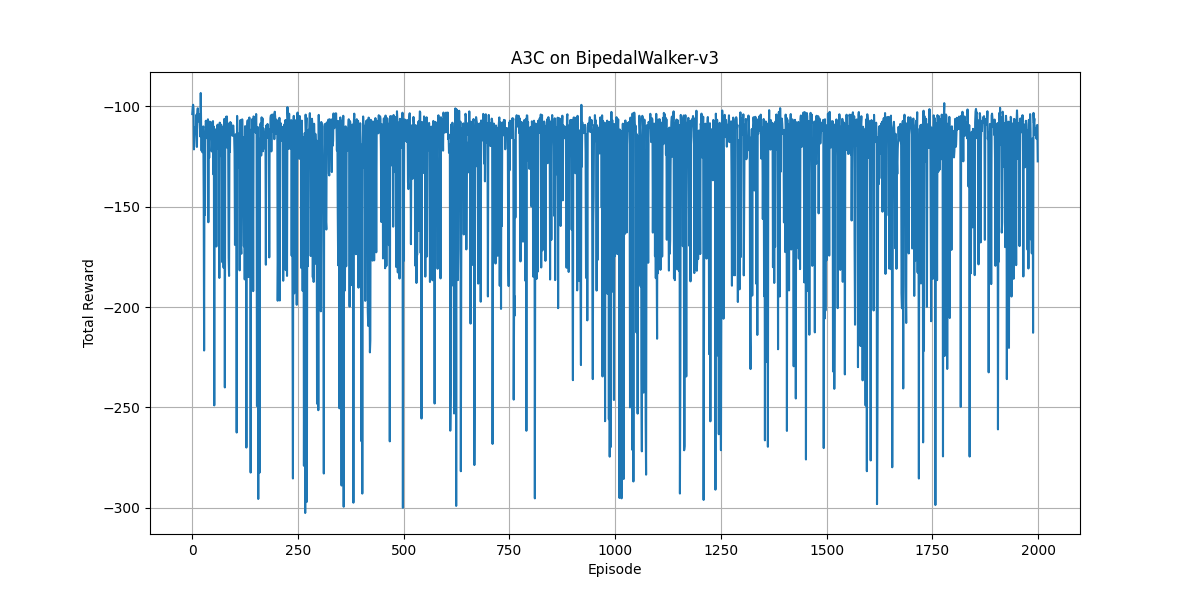

In [ ]:
from IPython.display import Image, display

display(Image('/content/results_BipedalWalker-v3_20250425-020340/total_rewards.png'))

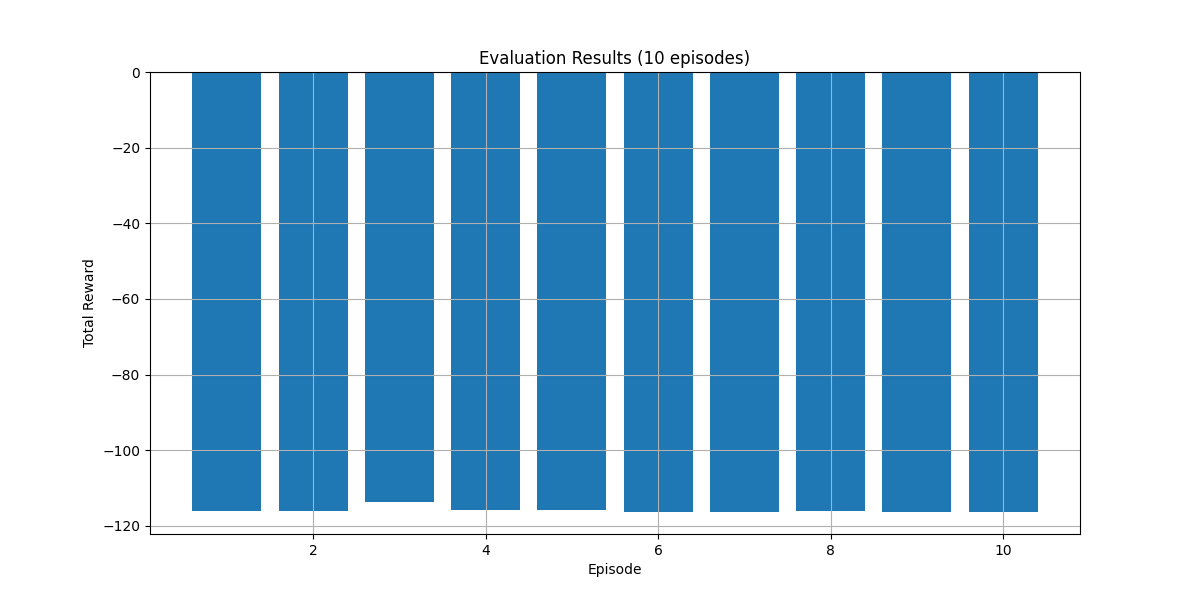

In [ ]:
from IPython.display import Image, display

display(Image('/content/results_BipedalWalker-v3_20250425-020340/evaluation_results.png'))